In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH





In [2]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [5]:
for id in mimicDF['PatientID'].unique()[:1]:
    patientDF = mimicDF[mimicDF['PatientID'] == id]
    display(patientDF)

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def find_cached(df=None, my_hash=None):

    if my_hash is None:
        my_hash = hashlib.sha256(bytes(str(df), 'utf-8')).hexdigest()

    display(my_hash)


    try:
        cachedDF = pd.read_csv("./processingCache/" + my_hash + ".csv").set_index("Unnamed: 0")

        print("Using cached df")

        return cachedDF, my_hash

    except:

        return False, my_hash
    

C:\Users\benma\AppData\Local\Temp/ipykernel_13788/857509499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
C:\Users\benma\AppData\Local\Temp/ipykernel_13788/857509499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()
100%|██████████| 1126/1126 [00:01<00:00, 652.32it/s]


[1/4] Counting null values...


100%|██████████| 1126/1126 [00:00<00:00, 1232.84it/s]


[2/3] Copying dataset...
[3/4] Dropping null columns...


100%|██████████| 39/39 [00:04<00:00,  9.35it/s]


[4/4] Graphing...


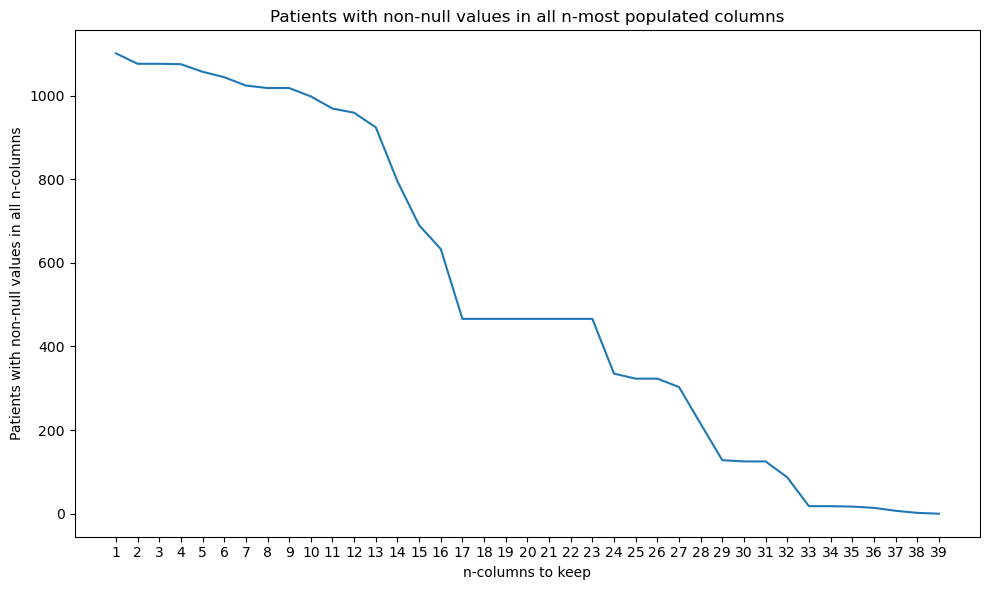

100%|██████████| 1126/1126 [00:00<00:00, 1605.77it/s]


In [7]:
# Fixing 'arterial pH', 'ionized calcium' since they contain erroneous values.

mimicDF['Arterial pH'][mimicDF['Arterial pH'] > 8] = mimicDF['Arterial pH'].mean()
mimicDF['Ionized Calcium'][mimicDF['Ionized Calcium'] > 8] = mimicDF['Ionized Calcium'].mean()

patients = th.get_patients(mimicDF)

patientsKept, columnsExplored = th.count_null(patients)

patients = th.get_top_columns(patients, 12)

In [8]:
patients[0].topColumns

,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# tsfresh can't handle missing values



for patient in tqdm(patients):
    patient.cleanedDF = copy.copy(patient.topColumns)
    # patient.cleanedDF = patient.cleanedDF.apply(lambda x: x.interpolate(method='polynomial', order=2) if x.count() > 3 else np.NaN)
    for col in patient.cleanedDF:
        nonNullCount = patient.cleanedDF[col].count()

        if (nonNullCount >= 3):
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='polynomial', order=2)
        elif nonNullCount == 1:
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='linear', limit_direction='both', limit=3)
        else:
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='linear', limit_direction='both', limit_area='inside')

        patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='linear', limit_direction='both', limit_area='outside')

        # patient.cleanedDF[col] = patient.cleanedDF[col].fillna(patient.cleanedDF[col].mean()).fillna(0)
    patient.cleanedDF["PatientID"] = patient.patientID
    # patient.cleanedDF = patient.cleanedDF.set_index(['PatientID'])
    
# formattedMimicDF = pd.DataFrame(columns=patients[0].data.columns)

# for patient in patients:
formattedMimicDF = pd.concat([patient.cleanedDF for patient in patients])

# formattedMimicDF = formattedMimicDF.set_index('PatientID')

display(formattedMimicDF)

100%|██████████| 959/959 [00:17<00:00, 55.48it/s]


,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI,PatientID
0,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
1,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
2,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
3,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
4,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998
44,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998
45,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998
46,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998


Display interpolation and fillna results here

In [10]:
formattedMimicDF.columns

Index(['Platelets', 'Arterial BP [Diastolic]', 'Arterial BP [Systolic]',
       'Arterial BP Mean', 'CVP', 'Arterial pH', 'Hemoglobin',
       'Arterial PaCO2', 'Arterial PaO2', 'SVR', 'Ionized Calcium', 'SVRI',
       'PatientID'],
      dtype='object')

100059


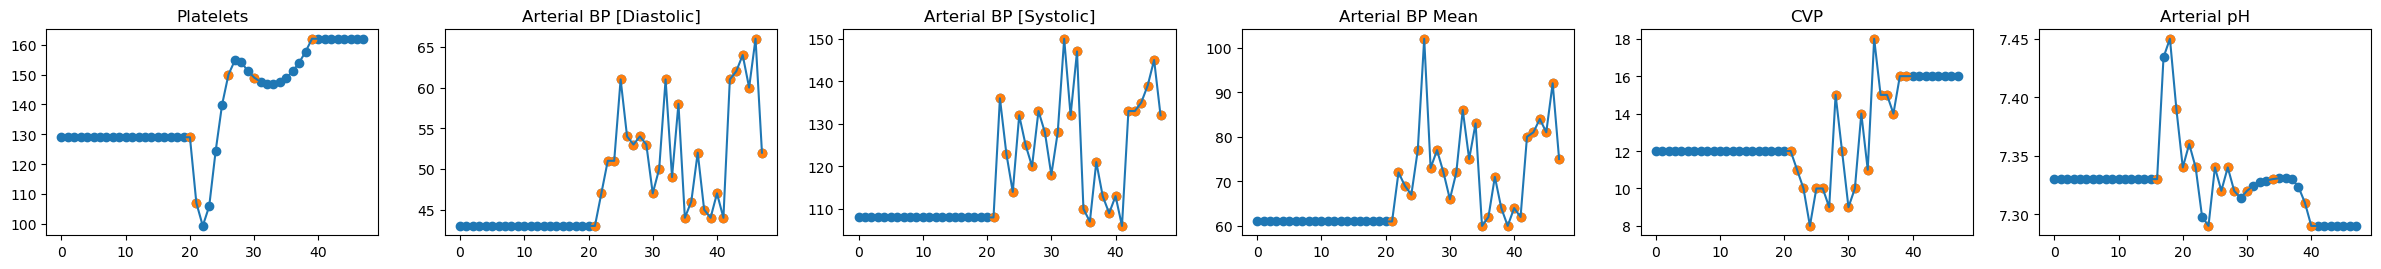

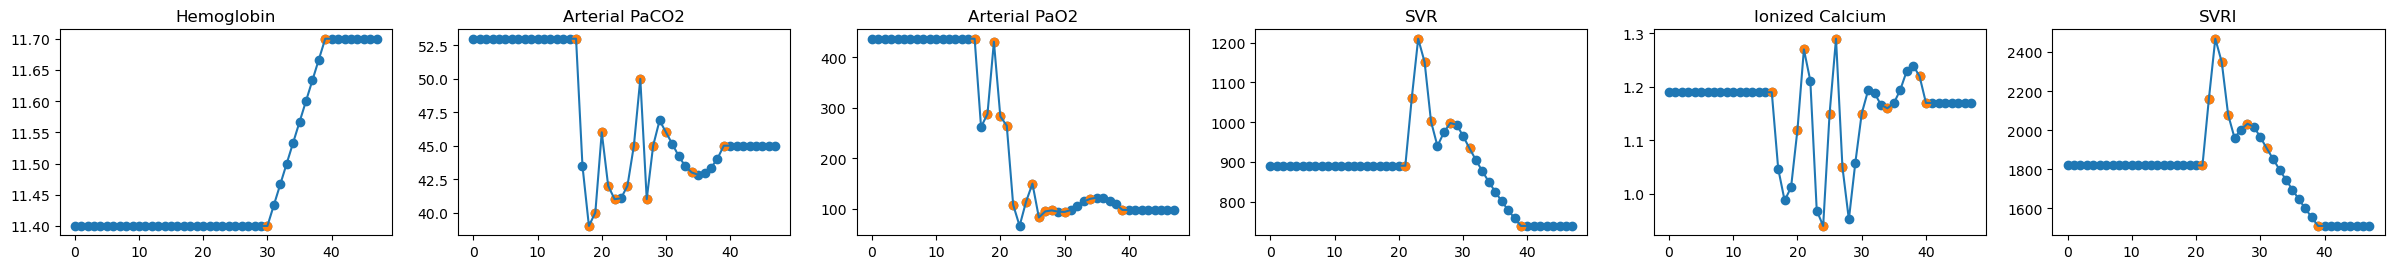

100298


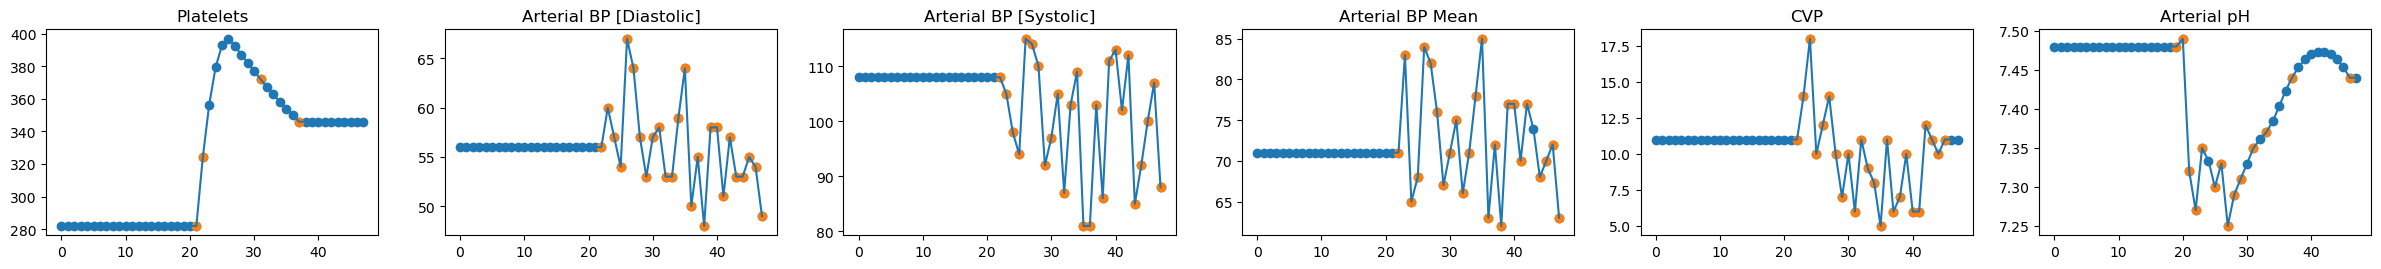

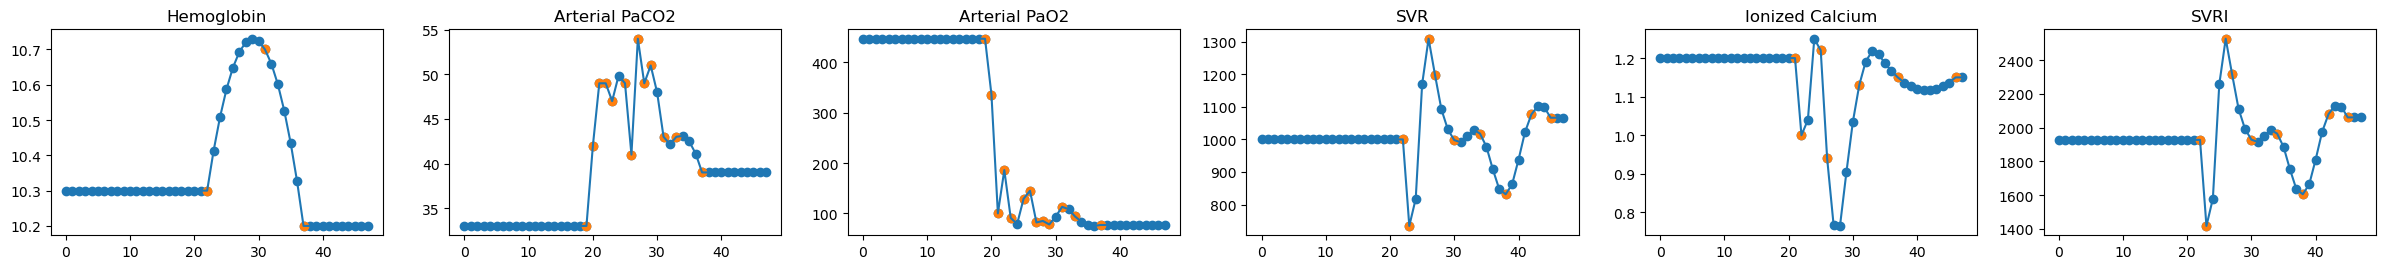

In [11]:
for patient in patients[:2]:

    # display(clusteringPatients[i].interpolatedData.head())

    print(patient.patientID)


    step = 6

    columns = list(patient.cleanedDF.columns)[:-1]

    for idx in range(0, len(columns), step):


        fig = plt.figure(figsize = (30, 6), dpi=100)

        cols = columns[idx:idx+step]


        for k, col in enumerate(cols):

            plt.subplot(2, step, k+1)

            plt.plot(patient.cleanedDF.index, patient.cleanedDF[col])
            plt.scatter(patient.cleanedDF.index, patient.cleanedDF[col])
            plt.scatter(patient.cleanedDF.index, patient.data[col])
            plt.title(f"{col}")

    plt.show()

In [12]:

targetSeries = pd.Series(data=[patient.label for patient in patients], index=[patient.patientID for patient in patients])

# targetSeriesFormatted = df.set_index(formattedMimicDF["PatientID"].unique()).iloc[:,0].sort_index()

type(targetSeries)


pandas.core.series.Series

In [13]:
formattedMimicDF

,Platelets,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial BP Mean,CVP,Arterial pH,Hemoglobin,Arterial PaCO2,Arterial PaO2,SVR,Ionized Calcium,SVRI,PatientID
0,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
1,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
2,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
3,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
4,129.0,43.0,108.0,61.0,12.0,7.33,11.4,53.0,437.0,890.755981,1.19,1819.739990,100059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998
44,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998
45,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998
46,144.0,45.0,124.0,68.0,13.0,7.39,9.3,38.0,109.0,695.081970,1.18,1376.619995,199998


In [14]:
## Checking if this DF already has cached time series features. Will save approx 15 mins if so.

# my_hash = hashlib.sha256(pd.util.hash_pandas_object(formattedMimicDF, index=True).values).hexdigest()

my_hash = "26128f35758669a6e2001768a98df93bff7b0b8ac8fdf241d94641c49a83b901"

filtered_features, my_hash = find_cached(formattedMimicDF, my_hash = my_hash)


if filtered_features is False:

    filtered_features = extract_relevant_features(formattedMimicDF, y=targetSeries, column_id="PatientID", n_jobs=4)

    # print("Imputing")
    # impute(extracted_features)

    # # Is this the right target series?
    # print("Filtering important features")
    # filtered_features = select_features(extracted_features, formattedMimicDF)

    filtered_features.to_csv("./processingCache/" + my_hash + ".csv")

'26128f35758669a6e2001768a98df93bff7b0b8ac8fdf241d94641c49a83b901'

Using cached df


In [ ]:
filtered_features = filtered_features.reindex(formattedMimicDF['PatientID'].unique())

filtered_features['PatientID'] = formattedMimicDF['PatientID'].unique()

filtered_features = filtered_features.set_index('PatientID')

display(filtered_features)

,CVP__quantile__q_0.3,CVP__quantile__q_0.4,CVP__quantile__q_0.2,CVP__minimum,CVP__quantile__q_0.1,CVP__median,CVP__mean,CVP__root_mean_square,CVP__quantile__q_0.6,CVP__c3__lag_3,CVP__c3__lag_2,CVP__c3__lag_1,CVP__variation_coefficient,CVP__quantile__q_0.7
PatientID,,,,,,,,,,,,,,
178177,5.0,6.0,5.000000,2.000000,2.304570,10.347350,10.481871,12.089007,17.0,1991.044181,2118.808407,2143.268993,0.574595,17.0
110594,10.0,10.0,9.000000,4.000000,7.700000,10.956433,11.818527,12.533960,12.2,1717.892085,1815.693849,2061.294823,0.353177,13.0
157699,10.0,10.0,10.000000,7.000000,9.700000,10.000000,11.541667,12.232130,10.0,1817.238095,1865.977273,2003.369565,0.351035,10.0
180230,11.0,12.8,11.000000,9.000000,10.000000,13.000000,12.979167,13.326821,13.0,2341.714286,2415.613636,2517.630435,0.232999,13.0
165898,11.0,11.8,9.000000,5.000000,7.000000,12.000000,12.204246,12.688859,12.2,1982.626610,2085.882896,2174.195900,0.284594,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,7.0,8.0,6.000000,-6.499985,3.054993,9.000000,8.038506,9.262189,10.0,639.696840,724.519262,786.160107,0.572389,11.0
116726,14.1,15.8,12.400000,1.000000,9.700000,17.000000,16.583333,17.498809,20.0,5406.214286,5626.772727,5840.652174,0.336833,20.9
169975,15.0,15.0,15.000000,14.000000,14.300000,15.000000,15.625000,15.720210,15.0,3944.888889,3937.200000,3942.681818,0.110562,15.0


In [ ]:
for col in filtered_features.columns:
    print(col)

CVP__quantile__q_0.3
CVP__quantile__q_0.4
CVP__quantile__q_0.2
CVP__minimum
CVP__quantile__q_0.1
CVP__median
CVP__mean
CVP__root_mean_square
CVP__quantile__q_0.6
CVP__c3__lag_3
CVP__c3__lag_2
CVP__c3__lag_1
CVP__variation_coefficient
CVP__quantile__q_0.7


In [ ]:
cat = Categorizer(filtered_features)

cat.agglomerative(n_clusters=5)

categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

# categories = {0: 'low', 1: 'medium', 2: 'high'}


mapped = cat.map_types(mapping=categories)['agglomerative']

display(mapped)

,CVP__quantile__q_0.3_high,CVP__quantile__q_0.3_low,CVP__quantile__q_0.3_medium,CVP__quantile__q_0.3_very_high,CVP__quantile__q_0.3_very_low,CVP__quantile__q_0.4_high,CVP__quantile__q_0.4_low,CVP__quantile__q_0.4_medium,CVP__quantile__q_0.4_very_high,CVP__quantile__q_0.4_very_low,...,CVP__variation_coefficient_high,CVP__variation_coefficient_low,CVP__variation_coefficient_medium,CVP__variation_coefficient_very_high,CVP__variation_coefficient_very_low,CVP__quantile__q_0.7_high,CVP__quantile__q_0.7_low,CVP__quantile__q_0.7_medium,CVP__quantile__q_0.7_very_high,CVP__quantile__q_0.7_very_low
PatientID,,,,,,,,,,,,,,,,,,,,,
178177,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
110594,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
157699,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
180230,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
165898,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
116726,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
169975,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
mapped['Mortality14Days'] = targetSeries

mapped.to_csv("./categorisedData/metricExtractedData.csv")